<h4>Исследование поведения пользователей мобильного приложения</h4>

##### План работы
<ul>
<li>Для работы с датафреймом изучим данные мобильного приложения, проведем предобработку, а затем приступим к исследованию.</li>
<li>В рамках исследования поведения пользователей мобильного приложения изучим воронку продаж, узнаем, как пользователи доходят до покупки, на каких шагах они застревают.</li>
<li>После этого исследуем результаты A/A/B-эксперимента и сделаем выводы.</li>
</ul>

##### Описание данных

На входе мы получили датасет с логами, где каждая запись в логе — это действие пользователя или событие. 

##### Изучение данных и предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import ttest_ind
import plotly.express as px

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Переименуем названия колонок.

In [4]:
data.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}, inplace=True)

In [5]:
data.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим типы данных.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Столбец 'EventTimestamp' должен иметь формат datetime, поменяем его.

In [7]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Проверим, есть ли в данных пропуски.

In [9]:
count = 0
shape_0 = data.shape[0]
for element in data.columns:
    if data[element].isna().sum() > 0: 
        print(element, ' - ', data[element].isna().sum(), 'пропусков, ', round(
            data[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
        count = +1
if count == 0:
        print('Пропусков НЕТ')

Пропусков НЕТ


Пропусков найдено не было.

Добавим столбец с датой.

In [10]:
data['date'] = data['event_timestamp'].dt.date
data['date'] = data['event_timestamp'].astype('datetime64[D]')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
 4   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [12]:
# проверим данные на дубликаты
num_duplicates = data.duplicated().sum()
num_duplicates

413

In [13]:
# посмотрим, сколько это процентов из всего датафрейма
total_rows = len(data)
percentage_duplicates = (num_duplicates / total_rows) * 100
print(percentage_duplicates)

0.16917493425526162


In [14]:
# В датафрейме почти 17% дубликатов, удалим их.

data = data.drop_duplicates().reset_index(drop=True)

###### Промежуточный вывод:

В рамках предобработки был изменен тип данных, названия колонок, а также произведена проверка пропусков и дубликатов – пропусков не оказалось, дубликаты были удалены. Был также добавлен новый столбец с датой.

##### Изучим и проверим данные.

In [15]:
# Сколько всего событий в логе?

data['event_timestamp'].count()

243713

Всего в логе 243713 событий.

In [16]:
# сколько всего пользователей в логе?

data['device_id_hash'].nunique()

7551

Всего в логе 7551 уникальный пользователь.

In [17]:
# Сколько в среднем событий приходится на пользователя?

data.groupby('device_id_hash')['event_timestamp'].count().mean()

32.27559263673685

В среднем  на пользователя приходится 32 события.

In [18]:
# Найдем максимальную и минимальную дату.

max_date = data['event_timestamp'].max()
min_date = data['event_timestamp'].min()

print("Максимальная дата:", max_date)
print("Минимальная дата:", min_date)

Максимальная дата: 2019-08-07 21:15:17
Минимальная дата: 2019-07-25 04:43:36


На первый взгляд мы располагаем данными с 25 июля по 7 августа 2019 года.

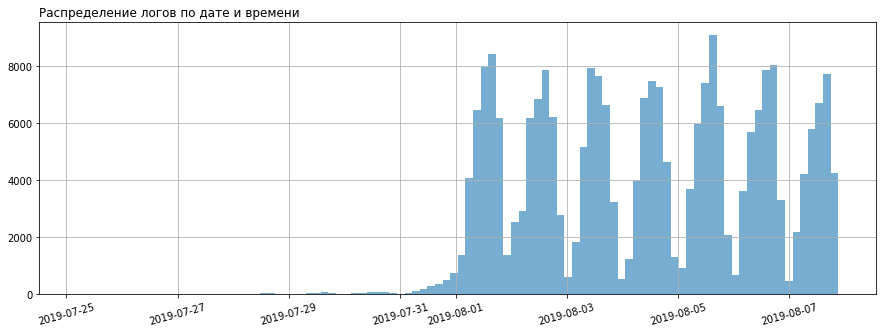

In [19]:
# Изучим распределение событий во времени
plt.title('Распределение логов по дате и времени', loc='left')
data['event_timestamp'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
plt.show()

По графику видно, что нет логов в период с 25 июля до 31 июля. Из исследования видно, что мы располагаем данными с 1 по 7 августа.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [21]:
# Отбросим старые данные и посчитаем, сколько событий и пользователей мы потеряли.
all_before_del = data.shape[0]
print('Всего логов до удаления:', all_before_del)
users_before_del = data['device_id_hash'].nunique()
print('Всего пользователей до удаления:', users_before_del)
data = data[data['date'] >= '2019-08-01']
after_del = data.shape[0]
print('Сколько логов потеряли:', (all_before_del - after_del))
users_after = data['device_id_hash'].nunique()
print('Сколько пользователей потеряли:', (users_before_del - users_after))

Всего логов до удаления: 243713
Всего пользователей до удаления: 7551
Сколько логов потеряли: 2826
Сколько пользователей потеряли: 17


In [22]:
# Пересчитаем потери в относительных показателях
print('Потери логов в %:', ((all_before_del - after_del) / all_before_del) * 100)
print('Потери юзеров в %:', ((users_before_del - users_after) / users_before_del) * 100)

Потери логов в %: 1.159560630741897
Потери юзеров в %: 0.22513574361011784


Потери не критичны.

In [23]:
# Проверим, есть ли у нас пользователи из трех экспериментальных групп.
data['exp_id'].unique()

array([246, 247, 248])

In [24]:
data.groupby('exp_id').agg({'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False)

,device_id_hash
exp_id,
248,84563
246,79302
247,77022


В датафрейме присутствуют пользователи из трех экспериментальных групп.

###### Промежуточные выводы:

Всего в логе 243713 событий, 7551 уникальный пользователь. В среднем на пользователя приходится 32 события.

Исследование показало, что мы располагаем данными с 1 по 7 августа 2019 года.


##### Изучим воронку событий

In [25]:
# Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
data.groupby('event_name').agg({'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False)

,device_id_hash
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Всего в датафрейме 5 уникальных событий: переход на основную страницу, предложения, тележка, успешная оплата, обучение. Наиболее часто встречающееся событие - это переход на главную страницу, меньше всего пользователи ходят на страницу с обучающим контентом.

In [26]:
# Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.Посчтаем долю пользователей, которые хоть раз совершали событие.
events_by_users = data.groupby('event_name')['device_id_hash'].nunique().reset_index(name='num_users')

events_by_users = events_by_users.sort_values(by='num_users', ascending=False)
events_by_users['rate'] = events_by_users['num_users'] / data['device_id_hash'].nunique() * 100
events_by_users

,event_name,num_users,rate
1,MainScreenAppear,7419,98.473586
2,OffersScreenAppear,4593,60.963632
0,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


Больше всего пользователей (почти все) заходили на основную страницу, меньше всего (11%) - пользовались обучающими материалами.46% конвертировались в платящих.

Можно предположить, что все события происходят последовательно, кроме шага с обучением. Возможно интерфейс и так понятен и пользователи не хотят тратить время на дополнительное обучение. Можно удалить этот шаг на этом этапе.


In [27]:
events_by_users['event_name'] = events_by_users[events_by_users['event_name'] != 'Tutorial']

In [28]:
# По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки. 

users = data.pivot_table(
    index='device_id_hash', 
    columns='event_name', 
    values='event_timestamp',
    aggfunc='min')


print('Ознакомились с предложениями в % от предыдущего шага:', 
      '({:.1%})'.format(users['OffersScreenAppear'].count() / users['MainScreenAppear'].count() ))
print('Положили товар в козину в % от предыдущего шага:', 
      '({:.1%})'.format(users['CartScreenAppear'].count() / users['OffersScreenAppear'].count()))
print('Произвели оплату в % от предыдущего шага:',
      '({:.1%})'.format(users['PaymentScreenSuccessful'].count() / users['CartScreenAppear'].count()))

Ознакомились с предложениями в % от предыдущего шага: (61.9%)
Положили товар в козину в % от предыдущего шага: (81.3%)
Произвели оплату в % от предыдущего шага: (94.8%)


Больше всего пользователей отваливаются на втором шаге. Возможно они понимают, что не будут сейчас делать покупок и поэтому уходят из приложения.

In [29]:
print('Произвели оплату в % от первого шага:',
      '({:.1%})'.format(users['PaymentScreenSuccessful'].count() / users['MainScreenAppear'].count()))

Произвели оплату в % от первого шага: (47.7%)


In [30]:
events_by_users = events_by_users[events_by_users['event_name'] != 'Tutorial']
events_by_users['total_users'] = data.pivot_table

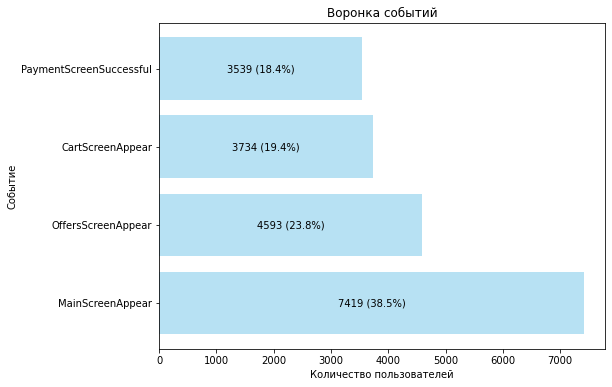

In [31]:
nan_mask = events_by_users['event_name'].apply(lambda x: isinstance(x, str) and x.lower() == 'nan')

events_by_users['event_name'] = events_by_users['event_name'].replace('nan', np.nan)

events_by_users = events_by_users.dropna(subset=['event_name'])

plt.figure(figsize=(8, 6))
plt.barh(events_by_users['event_name'], events_by_users['num_users'], color='skyblue', alpha=0.6)

for i, num_users in enumerate(events_by_users['num_users']):
    plt.text(num_users / 2, i, f'{num_users} ({num_users / events_by_users["num_users"].sum() * 100:.1f}%)',
             ha='center', va='center', color='black')

plt.title('Воронка событий')
plt.xlabel('Количество пользователей')
plt.ylabel('Событие')
plt.show()

47% пользователей доходят от первого шага воронки до оплаты.

##### Промежуточные выводы:

Всего в датафрейме 5 уникальных событий: переход на основную страницу, предложения, тележка, успешная оплата, обучение. Наиболее часто встречающееся событие - это переход на главную страницу, меньше всего пользователи ходят на страницу с обучающим контентом.

Больше всего пользователей (почти все) заходили на основную страницу, меньше всего (11%) - пользовались обучающими материалами.46% конвертировались в платящих.

Больше всего пользователей не доходят до второго шага – переход на страницу с предложениями. 47% пользователей доходят от первого шага воронки до оплаты.


##### Изучим результаты эксперимента.

In [32]:
# Сколько пользователей в каждой экспериментальной группе.
users_by_group = data.groupby('exp_id')['device_id_hash'].nunique().reset_index(name='num_users')
users_by_group

,exp_id,num_users
0,246,2484
1,247,2513
2,248,2537


В контрольной группе пользователей в 2 раза больше, чем в экспериментальной.

In [33]:
total_unique_users = data['device_id_hash'].nunique()

if total_unique_users == users_by_group['num_users'].sum():
    print("Каждый user id принадлежит только одной группе")
else:
    print("В датафрейме есть юзеры, принадлежащие к нескольким группам")

Каждый user id принадлежит только одной группе


In [34]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
data.groupby('device_id_hash').agg({'exp_id':'nunique'}).query('exp_id > 1') 

,exp_id
device_id_hash,


Предыдущие исследования показали, что самое популярное событие - переход на главную страницу 'MainScreenAppear'.

In [35]:
# Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп
filtered_data = data[(data['event_name'] == 'MainScreenAppear') & ((data['exp_id'] == 246) | (data['exp_id'] == 247))]
user_counts = filtered_data.groupby('exp_id')['device_id_hash'].nunique()
user_counts

exp_id
246    2450
247    2476
Name: device_id_hash, dtype: int64

Количество людей в каждой из групп, совершивших это событие, практически одинаково, в 247й чуть больше.

In [36]:
# Подсчитаем долю пользователей в контрольных группах, которые совершили это событие

total_users_246 = data[data['exp_id'] == 246]['device_id_hash'].nunique()
total_users_247 = data[data['exp_id'] == 247]['device_id_hash'].nunique()

percentage_246 = (filtered_data[filtered_data['exp_id'] == 246]['device_id_hash'].nunique() / total_users_246) * 100
percentage_247 = (filtered_data[filtered_data['exp_id'] == 247]['device_id_hash'].nunique() / total_users_247) * 100

print('Доля пользователей из группы 246, совершивших заход на основную страницу:', percentage_246)
print('Доля пользователей из группы 247, совершивших заход на основную страницу:', percentage_247)

Доля пользователей из группы 246, совершивших заход на основную страницу: 98.63123993558777
Доля пользователей из группы 247, совершивших заход на основную страницу: 98.52765618782333


Проверим, будет ли отличие между группами статистически достоверным.

Н0 - Доли посетителей, побывавших на основной странице, одинаковы.

Н1 - Доли посетителей, побывавших на основной странице, разные.

Попробуем сделать A/A тест через z-test, используя поправку Бонферрони для корректировки уровня значимости.

In [37]:
def z_test(group_1, group_2, event_name, alpha, n):

    bonferroni_alpha = alpha / n
 
    n_users = np.array([group_1['device_id_hash'].nunique(), 
                        group_2['device_id_hash'].nunique()])

    success = np.array([group_1[group_1['event_name'] == event_name]['device_id_hash'].nunique(), 
                        group_2[group_2['event_name'] == event_name]['device_id_hash'].nunique()])

    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    difference = p1 - p2 

    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2  
    
    print('Событие:', event_name)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [38]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event_name in events_by_users['event_name'].unique():
    z_test(data[data['exp_id'] == 246], data[data['exp_id'] == 247], event_name,.05, 16)
    
    print()

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Поскольку нет оснований считать доли контрольных групп разными, проведем A/B тест.

In [39]:
# проверим, есть ли статистически значимая разница между контрольной группой 246 и экспериментальной 248:
for event_name in events_by_users['event_name'].unique():
    z_test(data[data['exp_id'] == 246], data[data['exp_id'] == 248], event_name,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Так же нет оснований считать доли исследуемых групп разными.

In [40]:
# проверим, есть ли статистически значимая разница между контрольной группой 247 и экспериментальной 248:
for event_name in events_by_users['event_name'].unique():
    z_test(data[data['exp_id'] == 247], data[data['exp_id'] == 248], event_name,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результат аналогичный.

In [41]:
# проверим есть ли статистически значимая разница между контрольными и экпериментальной группами:
for event_name in events_by_users['event_name'].unique():
    z_test(data[data['exp_id'] != 248], data[data['exp_id'] == 248], event_name,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Результаты тестов показали, что изменение шрифтов во всём приложении на поведение пользователей не повлияло.

#### Выводы
<ul>
<li>В рамках работы были изучены данные мобильного приложения, проведена предобработка, а затем проведено исследование.</li>
<li>В рамках исследования поведения пользователей мобильного приложения была изучена воронка продаж, как пользователи доходят до покупки, на каких шагах они застревают, а также исследованы результаты A/A/B-эксперимента.</li>
<li>В рамках предобработки был изменен тип данных, названия колонок, а также произведена проверка пропусков – их не оказалось. Было найдено около 17% дубликатов, которые были удалены. Был также добавлен новый столбец с датой.</li>
<li>Всего в логе 243713 событий, 7551 уникальный пользователь. В среднем на пользователя приходится 32 события.</li>
<li>Исследование показало, что мы располагаем данными с 1 по 7 августа 2019 года.</li>
<li>Всего в датафрейме 5 уникальных событий: переход на основную страницу, предложения, тележка, успешная оплата, обучение. Наиболее часто встречающееся событие - это переход на главную страницу, меньше всего пользователи ходят на страницу с обучающим контентом.</li>
<li>Больше всего пользователей (почти все) заходили на основную страницу, меньше всего (11%) - пользовались обучающими материалами.46% конвертировались в платящих.</li>
<li>Больше всего пользователей не доходят до второго шага – переход на страницу с предложениями. 47% пользователей доходят от первого шага воронки до оплаты.</li>
<li>В контрольной группе пользователей в 2 раза больше, чем в экспериментальной.</li>
<li>Количество людей в каждой из групп, совершивших самое популярное событие – переход на главную страницу, практически одинаково, в 247-й чуть больше.</li>
<li>Изменение шрифтов во всём приложении на поведение пользователей не повлияло.</li>
</ul>